## Community detection for all metropolitan areas

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import networkx as nx

import scipy
import csv

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import json
import community as community_louvain
from copy import deepcopy
# from modularity_maximization.utils import get_modularity

from itertools import product
import networkx.algorithms.community as nx_comm
from scipy.spatial.distance import pdist, squareform

import math
from time import time

import matplotlib.lines as lines

## %matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from oct2py import octave
#octave.addpath('/home/ubuntu/GenLouvain/')
#octave.addpath('/home/ubuntu/GenLouvain/private/')
_ = octave.addpath('/home/barcsab/projects/urban_communities/scripts')
_ = octave.addpath('/home/ubuntu/GenLouvain/')
_ = octave.addpath('/home/ubuntu/GenLouvain/private/')

### data

In [5]:
# three networks - data IN
mobility = pd.read_csv("../data/usageousers_city_mobility_CT_networks.rpt.gz") ## basis of position and node importance calculations
follow_hh = pd.read_csv("../data/usageousers_city_follower_CT_HH_networks.rpt.gz")
follow_hh = follow_hh.rename(columns={"tract_home.1": "tract_home_1"})

# census tract name -> cbsacode
cbsacode = pd.read_csv("../data/cbsacode_shortname_tracts.csv",sep=";", index_col=0)
cbsacode['clean_name'] = cbsacode["short_name"].map(lambda s: s.split("/")[0].replace(' ','_').replace('.','').lower())
cbsacode['state'] = cbsacode['geoid'].map(lambda i: i[7:9])
cbsacode['county'] = cbsacode['geoid'].map(lambda i: i[9:12])
cbsacode['tract'] = cbsacode['geoid'].map(lambda i: i[12:18])

# census data
census_1 = pd.read_csv("../data/censusdata_top50_2012.csv")
census_2 = pd.read_csv("../data/censusdata_top50_2017.csv")

# reading geojson data, converting it to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

# Cartesian coordinate projection of tract centroids
tract_geoms['centroid'] = tract_geoms['geometry'].centroid
tract_center_dict = tract_geoms\
    .set_geometry('centroid',crs={'init':'epsg:4326'})\
    .to_crs({'init':'epsg:3785'})\
    .set_index('full_geoid')['centroid'].map(lambda p: p.coords[0]).to_dict()

counties = gpd.read_file('../data/tl_2012_us_county.shp') # KERDES

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [6]:
# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

census_1['geoid'] = census_1.apply(create_geoid,axis=1)
census_2['geoid'] = census_2.apply(create_geoid,axis=1)

census_1 = census_1.add_suffix('_1')
census_2 = census_2.add_suffix('_2')

# Functions

In [5]:
def create_graphs(city, g_type):
    """
    For a given city name, it generates a mobility and follower (home-home) graph.
    
    e.g. g_mob, g_fol_hh = create_graphs("Boston")
    
    It uses the previously loaded `mobility` and `follow_hh` pandas.DataFrames, in which
    the edges are listed for every city.
    
    Parameters:
    -----------
    city : str
        name of the city, see cbsacode dataframe -> clean_name
        
    g_type : str
        either "mob" as mobility or "fol_hh" as follow_hh 
        selects the type of graph to return
        
    Returns:
    --------
    
    g : networkx.Graph
        weighted undirected graph based on city name and g_type (e.g. follow_hh graph of Boston)
        
    """
    # city cbsacode based on name
    city_code = cbsacode[cbsacode.clean_name == city].iloc[0].cbsacode
    
    # select graph type
    if g_type == "mob":
        # filtering large dataframes for the given city code
        mob_df = mobility[(mobility["cbsacode"] == city_code)&(mobility["tract_home"]!=mobility["tract_work"])]

        # create graphs
        # create empty graphs
        g_mob = nx.DiGraph() # mobility graph - weights are counts

        # fill in the networks with data
        mob_df['w_edges'] = list(zip(mob_df.tract_home,mob_df.tract_work,mob_df.cnt))
        g_mob.add_weighted_edges_from(mob_df["w_edges"], weight='cnt')

        # ineffective and slow!
        for e in g_mob.edges():
            r = (e[1],e[0])

            if r in g_mob.edges():
                c1 = g_mob.edges[e]['cnt']
                c2 = g_mob.edges[r]['cnt']

                g_mob.edges[e]['cnt'] = c1 + c2
                g_mob.edges[r]['cnt'] = c1 + c2

        # then let's convert the mobility graph to udirected
        g_mob = g_mob.to_undirected()

        g = g_mob
        
    elif g_type == "fol_hh":            
        # filtering large dataframes for the given city code
        fol_hh_df = follow_hh[(follow_hh["cbsacode"] == city_code)&(follow_hh["tract_home"]!=follow_hh["tract_home_1"])]

        # create graphs
        # create empty graphs
        g_fol_hh = nx.Graph() # follow home-home graph - weights are counts

        # this is an undirected graph already in the dataframe
        fol_hh_df['w_edges'] = list(zip(fol_hh_df.tract_home,fol_hh_df.tract_home_1,fol_hh_df.cnt))
        g_fol_hh.add_weighted_edges_from(fol_hh_df["w_edges"], weight='cnt')
        
        g = g_fol_hh
        
    # TODO --> DONE
    # check data - if all nodes of the graph are in the tract_geom dataframe
    # e.g. in create_graphs()
    # if someone's not there, that is data error, print the tract_id, and leave the node out of the graph G
    # only after this should we calculate the Expert input data    
    while not set(g.nodes).issubset(set(tract_geoms.full_geoid)): # KERDES: ezt hogyan ellenőrizzem le?
        print('DATA ERROR. Node do(es) not have corresponding geodata, so dropped.')
        print('Dropped node(s):')
        nodes_to_drop = set(g.nodes).difference(set(tract_geoms.full_geoid))
        g.remove_nodes_from(nodes_to_drop)
    return g

In [6]:
def SpaMod(A,D,N,binnumber): # binnumber instead of b = binsize
    """
    Function that calculates the matrix for the clustering 
    based on spatial null model a la Expert.
    
    Parameters:
    -----------
    
    A : scipy.sparse.csr.csr_matrix
        adjacency matrix
    D : numpy.ndarray
        Distance matrix between the nodes
    N : numpy.matrix
        a measure of the importance of a node
        the number of users living(home-location) in the given tract
    binnumber : int
        number of distance bins (used in the estimation of the deterrence function)
    Returns:
    --------
    
    KERDES - ellenorizni
    ModularitySpa : 
    ModularityGN :
    """
    
    tic = time()
    
    print("Beginning of modularity function...");   
    # felesleges?? KERDES -- symmetrised matrix (doesn't change the outcome of community detection (arXiv:0812.1770))
    A = A + A.T ### KERDES KELL-e?? TODO ATGONDOLNI? ILLETVE LE KELL-e osztani 2-vel   / 2     
    b = D.max()/(binnumber-1) # MODIFIED
    
    # deterrence function
    det, detbins = np.histogram(
        D.flatten(),
        range = (0, np.ceil(D.max()/b)*b), # JAVITAS
        weights = np.array(A.todense()).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    normadet, _ = np.histogram(
        D.flatten(), 
        range = (0, np.ceil(D.max()/b)*b),
        weights = np.array(N*N.T).flatten(), 
        bins=int(np.ceil(D.max()/b))
    )
    det = det / normadet
    det[np.isnan(det)] = 0
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    
    #tic = toc
    
    print("Null modell...")
    
    # copmutation of the randomised correlations (preserving space), spatial
    # null-model
    nullmodelSpa = det[np.digitize(D,detbins,right=True)-1]
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    
    #tic = toc
    
    print("Modularity calc...")
    
    # the modularity matrix for the spatial null-model
    ModularitySpa=A-np.multiply(N*N.T, nullmodelSpa*A.sum())/(np.multiply(N*N.T,nullmodelSpa).sum())
    szamlalo = np.multiply(N*N.T, nullmodelSpa*A.sum())
    nevezo = np.multiply(N*N.T,nullmodelSpa).sum()
    
    # the modularity matrix for the GN null-model
    degree = degree = A.sum(axis=0) # JAVITVA np.squeeze(np.asarray(A.sum(axis=0))) # degree or strength of nodes || asarry for further usage
    nullmodelGN = degree.T*degree/degree.sum() # Newman-Girvan null-model
    ModularityGN = A - nullmodelGN
    
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    
    return ModularitySpa, ModularityGN

In [7]:
# CONSENSUS CLUSTERING
def consen(city, algorithm_type, g_type):
    """
    Function that does the consensus clustering based on the results
    of multiple runs of previous algorithms.
    
    Parameters:
    -----------
    
    city : str
        cityname to runt he consensus clustering for (see cbsacode.clean_name)
    algorithm_type: str
        either "ms" or "mgn" 
        selects the clustering algoritm type: spatail (a la Expert) or ordinary Louvain clustering with Girvan-Newman
    g_type : str
        either "mobility" or "follow_hh"
        selects the type of graph
        
    Returns:
    --------
    
    s_louv : dict
        tract_geoid -> partition label (int)
    """
    
    tic = time()

    print("Reading in necessary data...")
    csv = '../data/consensus_' + city + '_' + algorithm_type + '_' + g_type + '.csv'

    # results of multiple iterations from previous runs
    iters = pd.read_csv(csv)
    iters = iters.set_index('geoid')
    iters['clusts'] = [np.array(l) for l in iters.values.tolist()]

    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc

    print("Creating all possible node pairs...")
    # create all possible node pairs
    geoid_pairs = list(product(list(iters.index), list(iters.index)))
    consen_df = pd.DataFrame(geoid_pairs, columns=['geoid_1','geoid_2'])

    # remove selfloops
    consen_df = consen_df[consen_df.geoid_1!=consen_df.geoid_2]
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc

    print("Joining interation results to node pairs...")
    # joining iteration results as lists to both elements of the tract pair
    consen_df = pd.merge(consen_df, iters['clusts'], left_on = 'geoid_1', right_on = 'geoid')
    consen_df = pd.merge(consen_df, iters['clusts'], left_on = 'geoid_2', right_on = 'geoid')
    consen_df = consen_df.rename(columns = {'clusts_x': 'clusts_1', 'clusts_y': 'clusts_2'})
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc

    print("Counting same partitioning for node pairs...")
    # how many times are the two tracts (geoid_1 and geoid_2) clustered to the same community?
    # --> weights of a graph on which clustering gives the consensus clustering
    print("Calculating difference...")
    diff = np.array(consen_df['clusts_2'].tolist()) == np.array(consen_df['clusts_1'].tolist())
    del consen_df['clusts_1'], consen_df['clusts_2']
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc

    print("Getting number of zero differences...") # HIBA: KIDOB NODE-OT!!!
    consen_df['w'] = diff.sum(axis=1)
    del diff
    # consen_df = deepcopy(consen_df[consen_df['w']!=0]) ## KERDES: Miért dob ki nodeot? 0326 JAVITAS
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc

    print("Last Louvain...")
    # graph for consensus clustering
    print("Creating graph...")
    g_cons = nx.Graph() 
    g_cons.add_weighted_edges_from(consen_df[['geoid_1','geoid_2','w']].values, weight='w')
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc

    del consen_df, iters

    print("Running Louvain...")
    # Louvain community detection 
    s_louv = community_louvain.best_partition(g_cons, weight='w')
    toc = time()
    print("Done.","%.2f" % (toc-tic))
    tic = toc

    return s_louv

In [14]:
city_l = cbsacode.clean_name.unique()

In [15]:
from itertools import product

In [16]:
all_combs = product(city_l, ['mob','fol_hh'], ['ms','mgn'])
city, g_type, algorithm_type = list(all_combs)[0]
city, g_type, algorithm_type

('new_york', 'mob', 'ms')

# Adding data to overall table

In [17]:
con_df = pd.read_csv('../data/all_cons.csv')

In [18]:
# number of tracts per city
tract_sum = cbsacode.groupby('clean_name')[['clean_name']].count() 
tract_sum = tract_sum.rename(columns={'clean_name': 'sum_tracts'})

In [19]:
all_graphs_df = pd.DataFrame(columns=['clean_name','g_type','tracts_in_network'])
all_graphs_df.head()

,clean_name,g_type,tracts_in_network


In [20]:
# Counting nodes in networks
graph_combs = product(city_l, ['mob','fol_hh'])

for city, g_type in graph_combs:
    G = create_graphs(city, g_type)
    all_graphs_df = all_graphs_df.append({'clean_name': city, 'g_type' : g_type, 'tracts_in_network' : len(G.nodes)}, ignore_index=True)   

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
tract_no_df = pd.merge(all_graphs_df, tract_sum, how = 'left', left_on = 'clean_name', right_index = True)

In [22]:
# add it to THE dataset
con_df = pd.merge(con_df, tract_no_df, left_on = ['city','g_type'], right_on = ['clean_name','g_type'])
con_df = con_df.drop(columns = ['clean_name'])

In [23]:
con_df['county'] = con_df['geoid'].map(lambda i: i[9:12])

In [24]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score # Adjusted Mutual Information (adjusted against chance)
from sklearn.metrics.cluster import adjusted_rand_score # Adjusted Rand Index

In [25]:
# 2) Normalized Mutual Information
## How similar is the clustering to the county system? correlation, symmetric function
##  --> the higher the index the more similar the clustering to county system
all_combs = product(city_l, ['mob','fol_hh'], ['ms','mgn'])

nmi_all_df = pd.DataFrame(columns=['city','g_type','algorithm_type','nmi_to_counties','adj_nmi_to_counties','adj_rand_to_counties'])

for city, g_type, algorithm_type in all_combs:
    nmi_df = con_df[(con_df['city'] == city) & (con_df['g_type'] == g_type) & (con_df['algorithm_type'] == algorithm_type)]
    nmi = normalized_mutual_info_score(nmi_df['county'], nmi_df['S_cons'], average_method='arithmetic')
    a_nmi = adjusted_mutual_info_score(nmi_df['county'], nmi_df['S_cons'], average_method='arithmetic')
    a_rand = adjusted_rand_score(nmi_df['county'], nmi_df['S_cons'])
    nmi_all_df = nmi_all_df.append({'city': city, 'g_type' : g_type, 'algorithm_type' : algorithm_type, 'nmi_to_counties' : nmi, 'adj_nmi_to_counties' : a_nmi, 'adj_rand_to_counties' : a_rand}, ignore_index=True)   

In [27]:
# add it to THE dataset
con_df = pd.merge(con_df, nmi_all_df, left_on = ['city','g_type','algorithm_type'], right_on = ['city','g_type','algorithm_type'])

In [60]:
con_df = con_df.set_index('geoid')

In [61]:
con_df.to_csv('../data/graph_properties.csv')

In [148]:
set(nmi_all_df.nmi_to_counties)

{-1.1254392130959919e-15,
 -3.238180646155405e-16,
 -7.684783953783232e-17,
 4.090122788503587e-16,
 6.082435402832799e-16,
 1.271962632268071e-15,
 0.0029747818914699605,
 0.0035925289204828898,
 0.014539293969835844,
 0.015277139290625819,
 0.04249441360983782,
 0.05062796993550319,
 0.05251950863150476,
 0.053504132866109125,
 0.05985063851965621,
 0.06523572627356321,
 0.06593968062291714,
 0.06947043720863519,
 0.07479360262169747,
 0.08014095616096101,
 0.08170384785924048,
 0.08206415151393945,
 0.08349509250892011,
 0.08934495033091484,
 0.10318592045999994,
 0.12986015179049096,
 0.14194717041637764,
 0.1420805424893394,
 0.15551850663737563,
 0.15635112514543822,
 0.15872325544554722,
 0.16274424198369652,
 0.16317134188392202,
 0.16376196256993855,
 0.16853046481648182,
 0.1726228501665102,
 0.1785575932896748,
 0.18690972730730263,
 0.1917124987593985,
 0.19771782737626442,
 0.198850441420883,
 0.20016824954210521,
 0.20687997803697503,
 0.22094815094682943,
 0.229515464410

In [149]:
set(nmi_all_df.adj_nmi_to_counties)

{-0.0001982315923401932,
 -3.181549390098734e-15,
 -7.01792253630902e-16,
 -3.238180646155405e-16,
 4.1566880417684896e-16,
 1.8977592309691713e-15,
 2.8421384283592213e-15,
 0.0004379343520393495,
 0.005996789164549155,
 0.011499039724088495,
 0.030132072142967807,
 0.036473775323064506,
 0.04226385964606048,
 0.048127211185151016,
 0.05209728557288853,
 0.05588226965371865,
 0.06158539111070151,
 0.06291776899469897,
 0.06487980278617116,
 0.06816906046246946,
 0.07315516630485559,
 0.07341675752602578,
 0.07999515439602717,
 0.08026054780642367,
 0.09327035783002328,
 0.1258666087702266,
 0.1261257164915689,
 0.13072623605856024,
 0.13852874724472392,
 0.14689797677137817,
 0.14854928618164034,
 0.14912298608896604,
 0.15048067817301627,
 0.15504975740613927,
 0.15737390898679945,
 0.16566807741575296,
 0.1660479318346745,
 0.17153178072053676,
 0.17432630790057652,
 0.18129627774743734,
 0.18572648942351233,
 0.18949691736142682,
 0.19940108488073413,
 0.21227374481547437,
 0.21389

In [150]:
set(nmi_all_df.adj_rand_to_counties)

{-0.022864121540503782,
 -0.013077651736830214,
 -0.012192644216133848,
 -0.00978341966935897,
 -0.00903143707506121,
 -0.00011821724669258035,
 0.0,
 0.000927233205669476,
 0.0030076452234419648,
 0.0031835033375074684,
 0.004773737383480896,
 0.009688363191307654,
 0.011795823514964818,
 0.017697228371425257,
 0.017757966428097568,
 0.023805015206501492,
 0.02517393914950791,
 0.029691993624074466,
 0.03531633451970954,
 0.03613867479768068,
 0.03697400342269451,
 0.04461491803487519,
 0.047677356503469125,
 0.05448430541089521,
 0.06390052345797413,
 0.0673741151169116,
 0.06872136688680366,
 0.07005117797014826,
 0.07099141187338301,
 0.0746751693500421,
 0.07551510440897932,
 0.0802963598989318,
 0.08038930522611008,
 0.08063827428070108,
 0.0850962573730572,
 0.08649671754271128,
 0.08692069504241609,
 0.09253152169398027,
 0.0950894597053357,
 0.09679150825520076,
 0.09726201660394958,
 0.09753049777685047,
 0.09928813042530212,
 0.09992406463171598,
 0.10008182189607197,
 0.101

In [131]:
set(nmi_all_df.nmi_to_counties) ## HIBA 0 ALATTI, ES 1 FELETTI ERTEKEK

{-2.375,
 -1.0,
 -0.25,
 0.016327401304773906,
 0.017270309667959324,
 0.020398765252502414,
 0.021933241972437234,
 0.056655714418564436,
 0.057411404351582346,
 0.05987778261246492,
 0.06918187989316835,
 0.06948288133753097,
 0.07340835696442397,
 0.0836192232753613,
 0.0893504605272664,
 0.09000182967453103,
 0.10189236358430674,
 0.10448940463547175,
 0.11703200174448149,
 0.12568243073247046,
 0.13207669728298801,
 0.1377215296301438,
 0.15460861334178624,
 0.15669075638907753,
 0.1587330822716046,
 0.15876254791208919,
 0.16266465586759862,
 0.16430819225819077,
 0.16458766853772358,
 0.16918368337058398,
 0.17033426060072057,
 0.17106061924132496,
 0.17262326788629584,
 0.18248995917869532,
 0.18878522176831583,
 0.19506981835096698,
 0.19861835585316528,
 0.1990172213648886,
 0.20148909077052685,
 0.2070008401097803,
 0.22197001284634024,
 0.23265975621656954,
 0.24163845766333208,
 0.24424812491262837,
 0.24619506076240172,
 0.24698776029248623,
 0.24736087955289152,
 0.25215

## START FROM HERE
### plots from data

In [7]:
tract_clusters_df = pd.read_csv('../data/graph_properties.csv')

In [8]:
tract_clusters_df.head()

,geoid,S_cons,city,algorithm_type,g_type,modularity,tracts_in_network,sum_tracts,county,nmi_to_counties,adj_nmi_to_counties,adj_rand_to_counties
0,14000US36005021800,0,new_york,ms,mob,0.411038,4603,4609,5,0.368244,0.366663,0.146885
1,14000US36005026500,0,new_york,ms,mob,0.411038,4603,4609,5,0.368244,0.366663,0.146885
2,14000US36047016000,1,new_york,ms,mob,0.411038,4603,4609,47,0.368244,0.366663,0.146885
3,14000US36047054400,1,new_york,ms,mob,0.411038,4603,4609,47,0.368244,0.366663,0.146885
4,14000US34035050500,2,new_york,ms,mob,0.411038,4603,4609,35,0.368244,0.366663,0.146885


In [9]:
graphs_df = tract_clusters_df.groupby(['city','algorithm_type','g_type'])[['city','algorithm_type','g_type','modularity','tracts_in_network','sum_tracts','nmi_to_counties','adj_nmi_to_counties','adj_rand_to_counties']].max().reset_index() # LEELLENORIZNI, UGYANAZ-E, MINT AZ NMI DF

In [10]:
graphs_df.head()

,city,algorithm_type,g_type,adj_nmi_to_counties,adj_rand_to_counties,modularity,nmi_to_counties,sum_tracts,tracts_in_network
0,atlanta,mgn,fol_hh,0.521675,0.325522,0.280535,0.536659,947,940
1,atlanta,mgn,mob,0.587757,0.357970,0.412011,0.603074,947,947
2,atlanta,ms,fol_hh,0.126126,0.036139,0.153237,0.141947,947,940
3,atlanta,ms,mob,0.353124,0.157283,0.277414,0.373254,947,947
4,austin,mgn,fol_hh,0.155050,0.104118,0.228105,0.168530,348,345


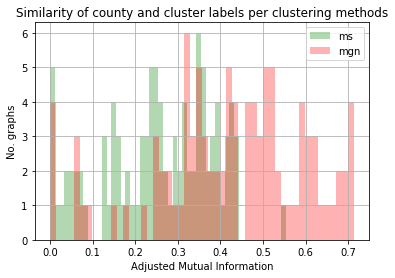

In [11]:
hist(graphs_df[graphs_df['algorithm_type'] == 'ms']['adj_nmi_to_counties'], color='green',bins = 50, alpha=0.3, label='ms')
hist(graphs_df[graphs_df['algorithm_type'] == 'mgn']['adj_nmi_to_counties'], color='red',bins = 50, alpha=0.3, label='mgn')
xlabel('Adjusted Mutual Information')
ylabel('No. graphs')
title('Similarity of county and cluster labels per clustering methods')
legend()
grid()

In [12]:
graphs_ms_mob_df = deepcopy(graphs_df[(graphs_df['algorithm_type'] == 'ms') & (graphs_df['g_type'] == 'mob')])
graphs_mgn_mob_df = deepcopy(graphs_df[(graphs_df['algorithm_type'] == 'mgn') & (graphs_df['g_type'] == 'mob')])
graphs_ms_fol_hh_df = deepcopy(graphs_df[(graphs_df['algorithm_type'] == 'ms') & (graphs_df['g_type'] == 'fol_hh')])
graphs_mgn_fol_hh_df = deepcopy(graphs_df[(graphs_df['algorithm_type'] == 'mgn') & (graphs_df['g_type'] == 'fol_hh')])

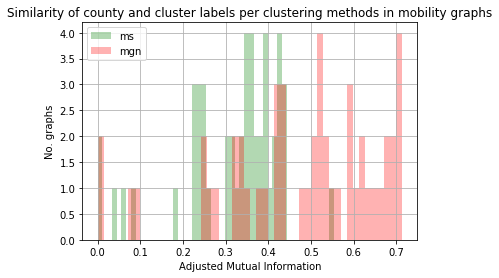

In [13]:
hist(graphs_ms_mob_df['adj_nmi_to_counties'], color='green',bins = 50, alpha=0.3, label='ms')
hist(graphs_mgn_mob_df['adj_nmi_to_counties'], color='red',bins = 50, alpha=0.3, label='mgn')
xlabel('Adjusted Mutual Information')
ylabel('No. graphs')
title('Similarity of county and cluster labels per clustering methods in mobility graphs')
legend()
grid()

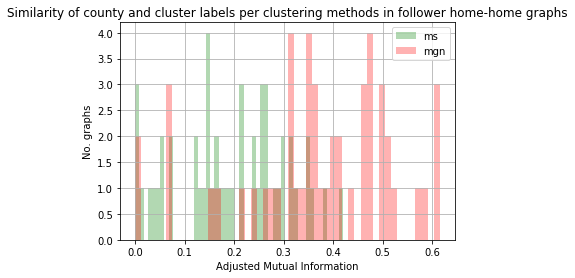

In [14]:
hist(graphs_ms_fol_hh_df['adj_nmi_to_counties'], color='green',bins = 50, alpha=0.3, label='ms')
hist(graphs_mgn_fol_hh_df['adj_nmi_to_counties'], color='red',bins = 50, alpha=0.3, label='mgn')
xlabel('Adjusted Mutual Information')
ylabel('No. graphs')
title('Similarity of county and cluster labels per clustering methods in follower home-home graphs')
legend()
grid()

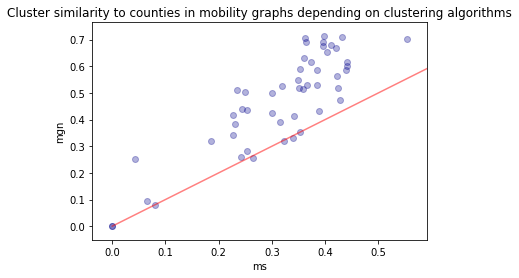

In [15]:
fig, ax = plt.subplots()
plt.title('Cluster similarity to counties in mobility graphs depending on clustering algorithms')
plt.xlabel('ms')
plt.ylabel('mgn')

ax.scatter(x = graphs_ms_mob_df.adj_nmi_to_counties, y = graphs_mgn_mob_df.adj_nmi_to_counties, c='DarkBlue', alpha=0.3)
line = lines.Line2D([0, 0.8], [0, 0.8], color='red', alpha=0.5)
ax.add_line(line)
plt.show()

# Inequality calculations

In [ ]:
TISZTÍTOTT ADATOT KELLENE HASZNALNI!!!!! FELADAT? HIBA, incomeban nem lehet 0

In [ ]:
# rey_Regional_convergence_inequality_and_space_2005_Review

In [16]:
tracts_df = pd.merge(tract_clusters_df, census_1, left_on = 'geoid', right_on = 'geoid_1')
tracts_df = pd.merge(tracts_df, census_2, left_on = 'geoid', right_on = 'geoid_2')
tracts_df = tracts_df.drop(columns = ['geoid_1', 'geoid_2'])
tracts_df['ones'] = 1 # for counting tract numbers in groups with sum()

In [17]:
# ELLENORIZNI, HOGY A TRACTS_DF-BEN CSAK OLYAN TRACT VAN, AMI HALOZATBAN IS VAN, MERT ERRE ALAPSZIK A KOVI SZAMITAS, UGYE??? Talan..

In [18]:
group_income_df = deepcopy(tracts_df[['geoid', 'S_cons', 'city', 'county', 'algorithm_type', 'g_type', 'income_1', 'income_2', 'ones']])

In [19]:
city_income_df = group_income_df.groupby(['city', 'algorithm_type', 'g_type']).sum().reset_index()
city_income_df = city_income_df.drop(columns = ['S_cons', 'county'])
city_income_df = city_income_df.rename(columns = {'income_1' : 'income_1_city_sum', 'income_2' : 'income_2_city_sum', 'ones' : 'tracts_in_city'})

In [20]:
clust_income_df = group_income_df.groupby(['city', 'algorithm_type', 'g_type', 'S_cons']).sum().reset_index()
clust_income_df = clust_income_df.drop(columns = ['county'])
clust_income_df = clust_income_df.rename(columns = {'income_1' : 'income_1_clust_sum', 'income_2' : 'income_2_clust_sum', 'ones' : 'tracts_in_clust'})
clust_income_df = pd.merge(clust_income_df, city_income_df, on = ['city', 'algorithm_type', 'g_type'])

In [21]:
county_income_df = group_income_df.groupby(['city', 'algorithm_type', 'g_type', 'county']).sum().reset_index()
county_income_df = county_income_df.drop(columns = ['S_cons'])
county_income_df = county_income_df.rename(columns = {'income_1' : 'income_1_county_sum', 'income_2' : 'income_2_county_sum', 'ones' : 'tracts_in_county'})
county_income_df = pd.merge(county_income_df, city_income_df, on = ['city', 'algorithm_type', 'g_type'])

In [22]:
clust_income_df.head()

,city,algorithm_type,g_type,S_cons,income_1_clust_sum,income_2_clust_sum,tracts_in_clust,income_1_city_sum,income_2_city_sum,tracts_in_city
0,atlanta,mgn,fol_hh,0,4962456.0,5335301.0,194,27442359.0,30307948.0,940
1,atlanta,mgn,fol_hh,1,8557002.0,9551018.0,194,27442359.0,30307948.0,940
2,atlanta,mgn,fol_hh,2,4722179.0,5211615.0,232,27442359.0,30307948.0,940
3,atlanta,mgn,fol_hh,3,6801424.0,7525531.0,231,27442359.0,30307948.0,940
4,atlanta,mgn,fol_hh,4,2399298.0,2684483.0,89,27442359.0,30307948.0,940


In [ ]:
# T = TB(between) + TW(within)  CALCULATIONS FROM rey_Regional_convergence_inequality_and_space_2005_Review

# 1) FOR CLUSTER AS GROUPS for income_1 and income_2 simultaneously

# 1.1
clust_income_df['s_g_1'] = clust_income_df['income_1_clust_sum'] / clust_income_df['income_1_city_sum']
clust_income_df['s_g_2'] = clust_income_df['income_2_clust_sum'] / clust_income_df['income_2_city_sum']

# TB before summing up for all groups
# KERDES: TERMESZETES LOGARITMUS KELL? Zárójelezés jó?
clust_income_df['TB_group_share_1'] = clust_income_df['s_g_1'] * ((clust_income_df['tracts_in_city']/(clust_income_df['tracts_in_clust'] * clust_income_df['s_g_1'])).map(lambda x : math.log(x)))
clust_income_df['TB_group_share_2'] = clust_income_df['s_g_2'] * ((clust_income_df['tracts_in_city']/(clust_income_df['tracts_in_clust'] * clust_income_df['s_g_2'])).map(lambda x : math.log(x)))

group_income_df = pd.merge(group_income_df, clust_income_df, on = ['S_cons', 'city', 'algorithm_type', 'g_type']) # on clusters
# KERDES: A MERGE MIERT KELL KULON CELLÁBAN FUSSON? MIERT NEM MERGELHETEM EZT A CELLÁT A KÖVETKEZŐVEL??

In [ ]:
# 1.2
group_income_df['s_i_g_1'] = group_income_df['income_1'] / group_income_df['income_1_clust_sum']
group_income_df['s_i_g_2'] = group_income_df['income_2'] / group_income_df['income_2_clust_sum']

group_income_df['A_1'] = group_income_df['s_i_g_1'] * ((group_income_df['tracts_in_clust'] * group_income_df['s_i_g_1']).map(lambda x : math.log(x)))
# HIBA group_income_df['A_2'] = group_income_df['s_i_g_2'] * ((group_income_df['tracts_in_clust'] * group_income_df['s_i_g_2']).map(lambda x : math.log(x)))

# summing up A-s --> group by "group" - clusters here
clust_aux_df = group_income_df.groupby(['S_cons', 'city', 'algorithm_type', 'g_type'])[['city', 'algorithm_type', 'g_type', 'A_1']].sum().reset_index()
# KERDES: a masodik zarojelbol miert kell kivennem az S_cons-t??
clust_aux_df = clust_aux_df.rename(columns = {'A_1' : 'A_1_sum'})
#clust_aux_df = group_income_df.groupby(['S_cons', 'city', 'algorithm_type', 'g_type'])[['city', 'algorithm_type', 'g_type', 'A_2']].sum().reset_index()
#clust_aux_df = clust_aux_df.rename(columns = {'A_2' : 'A_2_sum'})

clust_income_df = pd.merge(clust_income_df, clust_aux_df,  on = ['S_cons', 'city', 'algorithm_type', 'g_type'])  # on clusters

In [63]:
# 1.3
clust_income_df['TW_group_share_1'] = clust_income_df['s_g_1'] * clust_income_df['A_1_sum']
#clust_income_df['TW_group_share_2'] = clust_income_df['s_g_2'] * clust_income_df['A_2_sum']

# summing up the groups to city level
T_clust_df = clust_income_df.groupby(['city', 'algorithm_type', 'g_type']).sum().reset_index()[['city', 'algorithm_type', 'g_type', 'income_1_clust_sum', 'income_2_clust_sum', 'TB_group_share_1', 'TW_group_share_1']]#,'TB_group_share_2', 'TW_group_share_2']]
T_clust_df = T_clust_df.rename(columns = {'income_1_clust_sum' : 'income_1_city_sum', 'income_2_clust_sum' : 'income_2_city_sum', 'TB_group_share_1' : 'TB_1', 'TW_group_share_1' : 'TW_1'})

In [67]:
T_clust_df['income_growth_p'] = (T_clust_df['income_2_city_sum'] - T_clust_df['income_1_city_sum']) / T_clust_df['income_1_city_sum']
T_clust_df['T_1'] = T_clust_df['TB_1'] + T_clust_df['TW_1']
T_clust_df['TB_share'] = T_clust_df['TB_1'] / T_clust_df['T_1']
T_clust_df['TW_share'] = T_clust_df['TW_1'] / T_clust_df['T_1']

In [70]:
T_clust_df.head()

,city,algorithm_type,g_type,income_1_city_sum,income_2_city_sum,TB_1,TW_1,T_1,TB_share,TW_share,income_growth_p
0,atlanta,mgn,fol_hh,27442359.0,30307948.0,3.106349,0.075516,3.181864,0.976267,0.023733,0.104422
1,atlanta,mgn,mob,27740850.0,30624465.0,3.511512,0.075232,3.586744,0.979025,0.020975,0.103948
2,atlanta,ms,fol_hh,27442359.0,30307948.0,1.768368,0.083911,1.852279,0.954699,0.045301,0.104422
3,atlanta,ms,mob,27740850.0,30624465.0,3.104252,0.094266,3.198517,0.970528,0.029472,0.103948
4,austin,mgn,fol_hh,10897532.0,-653941977.0,2.647378,0.086250,2.733628,0.968449,0.031551,-61.008264


In [86]:
from numpy.polynomial.polynomial import polyfit

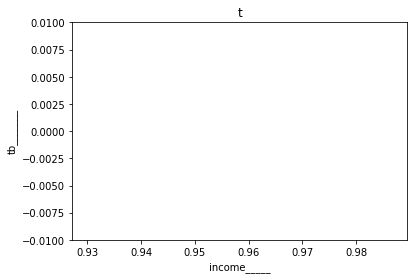

In [105]:
fig, ax = plt.subplots()
plt.title('t')
plt.xlabel('income_____')
plt.ylabel('tb_______')

#ax.scatter(x = T_clust_df['income_growth_p'], y = T_clust_df['TB_share'], c='DarkBlue', alpha=0.1)

# Fit with polyfit
b, m = polyfit(T_clust_df['TB_share'], T_clust_df['income_growth_p'], 1)

plt.plot(T_clust_df['TB_share'], b + m * T_clust_df['TB_share'], '-')
plt.ylim(-0.01,0.01)
plt.show()

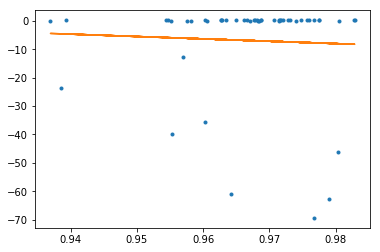

In [119]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

df = deepcopy(T_clust_df[(T_clust_df['income_growth_p'] >= -1000) & (T_clust_df['algorithm_type'] == 'ms') & (T_clust_df['g_type'] == 'fol_hh')]) ## HHIIIBBAAA SZURT ADATNAL KI KELL VENNI

# Sample data
x = df['TB_share']
y = df['income_growth_p']

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

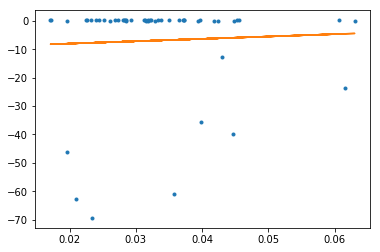

In [120]:
df = deepcopy(T_clust_df[(T_clust_df['income_growth_p'] >= -1000) & (T_clust_df['algorithm_type'] == 'ms') & (T_clust_df['g_type'] == 'fol_hh')]) ## HHIIIBBAAA SZURT ADATNAL KI KELL VENNI

# Sample data
x = df['TW_share']
y = df['income_growth_p']

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

In [ ]:
hist(T_clust_df['TB_share'], color='green',bins = 50, alpha=0.3, label='TB_share')
hist(T_clust_df['TW_share'], color='red',bins = 50, alpha=0.3, label='TW_share')
xlabel('Adjusted Mutual Information')
ylabel('No. graphs')
title('Similarity of county and cluster labels per clustering methods in follower home-home graphs')
legend()
grid()

,city,algorithm_type,g_type,TB_1,TW_1
0,atlanta,mgn,fol_hh,3.106349,0.075516
1,atlanta,mgn,mob,3.511512,0.075232
2,atlanta,ms,fol_hh,1.768368,0.083911
3,atlanta,ms,mob,3.104252,0.094266
4,austin,mgn,fol_hh,2.647378,0.086250
5,austin,mgn,mob,3.141806,0.106418
6,austin,ms,fol_hh,2.326706,0.086476
7,austin,ms,mob,2.507478,0.100141
8,baltimore,mgn,fol_hh,2.726004,0.062069
9,baltimore,mgn,mob,3.505832,0.055892


# Counties

In [90]:
cbsacode

,geoid,cbsacode,short_name,clean_name,state,county,tract
0,14000US34003001000,35620.0,New York,new_york,34,003,001000
1,14000US34003002100,35620.0,New York,new_york,34,003,002100
2,14000US34003002200,35620.0,New York,new_york,34,003,002200
3,14000US34003002300,35620.0,New York,new_york,34,003,002300
4,14000US34003003100,35620.0,New York,new_york,34,003,003100
5,14000US34003003200,35620.0,New York,new_york,34,003,003200
6,14000US34003003300,35620.0,New York,new_york,34,003,003300
7,14000US34003003401,35620.0,New York,new_york,34,003,003401
8,14000US34003003402,35620.0,New York,new_york,34,003,003402
9,14000US34003003500,35620.0,New York,new_york,34,003,003500


In [61]:
set(counties.CBSAFP)

{'10020',
 '10100',
 '10140',
 '10180',
 '10220',
 '10260',
 '10300',
 '10380',
 '10420',
 '10460',
 '10500',
 '10540',
 '10580',
 '10620',
 '10660',
 '10700',
 '10740',
 '10760',
 '10780',
 '10820',
 '10860',
 '10880',
 '10900',
 '10940',
 '10980',
 '11020',
 '11060',
 '11100',
 '11140',
 '11180',
 '11220',
 '11260',
 '11300',
 '11340',
 '11380',
 '11420',
 '11460',
 '11500',
 '11540',
 '11580',
 '11620',
 '11660',
 '11700',
 '11740',
 '11780',
 '11820',
 '11860',
 '11900',
 '11940',
 '11980',
 '12020',
 '12060',
 '12100',
 '12140',
 '12180',
 '12220',
 '12260',
 '12300',
 '12380',
 '12420',
 '12460',
 '12540',
 '12580',
 '12620',
 '12660',
 '12700',
 '12740',
 '12780',
 '12820',
 '12860',
 '12900',
 '12940',
 '12980',
 '13020',
 '13060',
 '13100',
 '13140',
 '13180',
 '13220',
 '13260',
 '13300',
 '13340',
 '13380',
 '13420',
 '13460',
 '13500',
 '13540',
 '13620',
 '13660',
 '13700',
 '13740',
 '13780',
 '13820',
 '13860',
 '13900',
 '13940',
 '13980',
 '14020',
 '14060',
 '14100',


In [49]:
len(counties.GEOID.unique())

3234

In [53]:
counties.nunique()

STATEFP       56
COUNTYFP     329
COUNTYNS    3234
GEOID       3234
NAME        1921
NAMELSAD    1968
LSAD          11
CLASSFP        5
MTFCC          1
CSAFP        128
CBSAFP       955
METDIVFP      29
FUNCSTAT       7
ALAND       3234
AWATER      3234
INTPTLAT    3234
INTPTLON    3234
geometry    3234
dtype: int64

## To be deleted

In [102]:
# unique values in the network counted by side of edge

mob_u_h = mobility.tract_home.tolist()
mob_u_w = mobility.tract_work.tolist()
u_geoid_mob = set([*mob_u_h,*mob_u_w])
cbsacode['in_mob'] = cbsacode.geoid.isin(u_geoid_mob).astype(int)

fol_u_h = follow_hh.tract_home.tolist()
fol_u_h1 = follow_hh.tract_home_1.tolist()
u_geoid_fol = set([*fol_u_h,*fol_u_h1])
cbsacode['in_fol'] = cbsacode.geoid.isin(u_geoid_fol).astype(int)

In [113]:
netw_count = cbsacode.groupby('cbsacode')[['in_mob','in_fol']].sum()

In [114]:
city_df = pd.merge(tract_sum, netw_count, left_index=True, right_index=True)

In [12]:
tract = mobility.groupby('tract_home')[['cnt']].sum()

In [13]:
tract.head()

,cnt
tract_home,
14000US01007010001,9
14000US01007010002,14
14000US01007010003,10
14000US01007010004,22
14000US01009050101,21
14000US01009050102,29
14000US01009050200,20
14000US01009050300,12
14000US01009050400,1


In [ ]:
%%writefile toto.m

function [a, b] = toto(c);
    a = c;
    b = c + 1;
end

In [ ]:
a,b = octave.toto(3, nout=2)